In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

/Users/Kadibhai/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hp_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

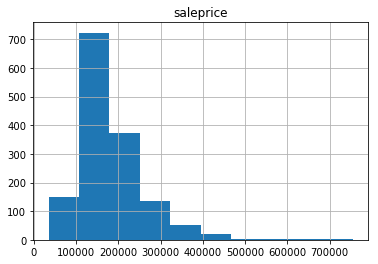

In [3]:
hp_df.hist('saleprice')

plt.show()

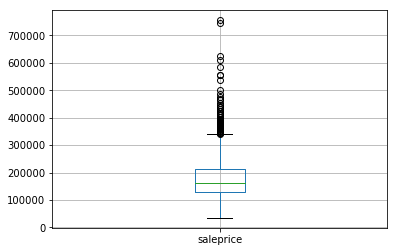

In [4]:
hp_df.boxplot('saleprice')
plt.show()

In [5]:
from scipy.stats.mstats import winsorize

hp_df['saleprice'] = winsorize(hp_df["saleprice"], (0.0, 0.05))

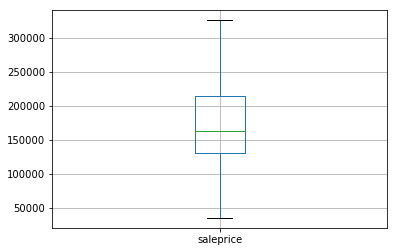

In [6]:
hp_df.boxplot('saleprice')
plt.show()

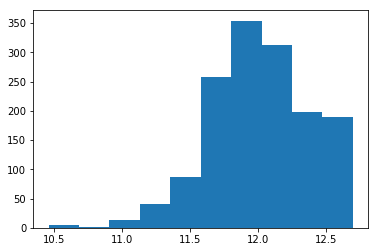

In [7]:
hp = np.log(hp_df['saleprice'])

plt.hist(hp)
plt.show()

In [8]:
hp_df.corr().saleprice.sort_values(ascending=False
                                )

saleprice        1.000000
overallqual      0.817302
grlivarea        0.698896
garagecars       0.673251
garagearea       0.650682
totalbsmtsf      0.607060
firstflrsf       0.595839
fullbath         0.587478
yearbuilt        0.573333
yearremodadd     0.556189
garageyrblt      0.529109
totrmsabvgrd     0.528495
fireplaces       0.487817
masvnrarea       0.437575
bsmtfinsf1       0.366059
lotfrontage      0.355445
openporchsf      0.339091
wooddecksf       0.337500
secondflrsf      0.318260
halfbath         0.296301
lotarea          0.262168
bsmtfullbath     0.238510
bsmtunfsf        0.227253
bedroomabvgr     0.183811
screenporch      0.109778
mosold           0.068987
poolarea         0.055844
threessnporch    0.050442
bsmtfinsf2      -0.006533
miscval         -0.019959
bsmthalfbath    -0.026427
id              -0.027107
yrsold          -0.032102
lowqualfinsf    -0.041494
overallcond     -0.073638
mssubclass      -0.084259
enclosedporch   -0.141650
kitchenabvgr    -0.150762
Name: salepr

In [9]:
pd.isnull(hp_df).sum()

id                  0
mssubclass          0
mszoning            0
lotfrontage       259
lotarea             0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
overallqual         0
overallcond         0
yearbuilt           0
yearremodadd        0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype          8
masvnrarea          8
exterqual           0
extercond           0
foundation          0
                 ... 
bedroomabvgr        0
kitchenabvgr        0
kitchenqual         0
totrmsabvgrd        0
functional          0
fireplaces          0
fireplacequ       690
garagetype         81
garageyrblt        81
garagefinish       81
garagecars          0
garagearea          0
garagequal         81
garagecond         81
paveddrive

In [10]:
# identify non numeric columns

non_numeric_columns = hp_df.select_dtypes(['object']).columns
print(non_numeric_columns)

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')


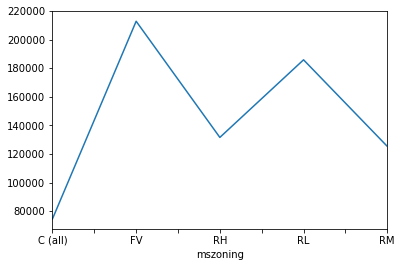

In [11]:
hp_loc = hp_df.groupby('mszoning')['saleprice'].mean()
hp_loc.plot()

In [12]:
## combining features to improve model
hp_df['total_sf'] = hp_df['totalbsmtsf'] + hp_df['firstflrsf'] + hp_df['secondflrsf']
hp_df['int_over_sf'] = hp_df['total_sf'] * hp_df['overallqual']

hp_df = pd.concat([hp_df,pd.get_dummies(hp_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
hp_df = pd.concat([hp_df,pd.get_dummies(hp_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(hp_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(hp_df.street, prefix="street", drop_first=True).columns)

In [13]:
# Y is the target variable
Y = np.log(hp_df['saleprice'])
# X is the feature set
X = hp_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf','total_sf','int_over_sf'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

results = sm.OLS(y_train, X_train).fit(cv=4)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     500.9
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:14:36   Log-Likelihood:                 537.37
No. Observations:                1168   AIC:                            -1049.
Df Residuals:                    1155   BIC:                            -982.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.5235      0.087    109.356      0.000       9.353       9.694
overallqual     0.2184      0.009     25.485      0.000       0.202       0.235
grlivarea   -4.168e-05   8.82e-05     -0.473      0.636      -0.000       0.000
garagecars      0.0665      0.014      4.885      0.000       0.040       0.093
garagearea      0.0001   4.72e-05      3.121      0.002    5.47e-05       0.000
totalbsmtsf    -0.0001   9.15e-05     -1.329      0.184      -0.000    5.79e-05
total_sf        0.0005   9.26e-05      5.461      0.000       0.000       0.001
int_over_sf -4.069e-05   2.76e-06    -14.754      0.000   -4.61e-05   -3.53e-05
mszoning_FV     0.6018      0.062      9.775      0.000       0.481       0.723
mszoning_RH     0.4391      0.072      6.137      0.000       0.299       0.580
mszoning_RL     0.5854      0.058     10.147      0.000       0.472       0.699
mszoning_RM     0.4267      0.058      7.310      0.000       0.312       0.541
street_Pave    -0.0245      0.066     -0.372      0.710      -0.154       0.105
==============================================================================
Omnibus:                      225.328   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              699.957
Skew:                          -0.951   Prob(JB):                    1.01e-152
Kurtosis:                       6.281   Cond. No.                     5.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

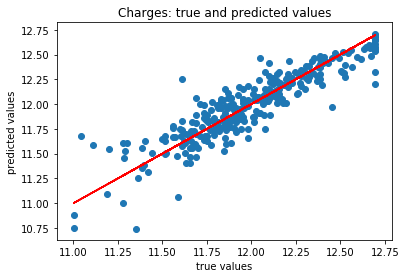

-----Test set statistics-----
Mean absolute error of the prediction is: 0.11605421971520874
Mean squared error of the prediction is: 0.025152685715902776
Root mean squared error of the prediction is: 0.15859598266003705
Mean absolute percentage error of the prediction is: 0.9759382754095951


In [14]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()
print("-----Test set statistics-----")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [15]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8386185891423593
-----Test set statistics-----
R-squared of the model in test set is: 0.8034310281270466
Mean absolute error of the prediction is: 0.11579605476448229
Mean squared error of the prediction is: 0.024731616379371588
Root mean squared error of the prediction is: 0.15726288939025504
Mean absolute percentage error of the prediction is: 0.9736718929393576


In [16]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8387000814992638
-----Test set statistics-----
R-squared of the model in test set is: 0.8026978519714633
Mean absolute error of the prediction is: 0.11586002197932802
Mean squared error of the prediction is: 0.02482386202346087
Root mean squared error of the prediction is: 0.1575559012651093
Mean absolute percentage error of the prediction is: 0.9742326992407482


### all three models perform similarly with good performance across test sets 